In [392]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set()

# Data Description (copied from Kaggle)

The training dataset consists of approximately 145k time series. Each of these time series represent a number of daily views of a different Wikipedia article, starting from July, 1st, 2015 up until December 31st, 2016. The leaderboard during the training stage is based on traffic from January, 1st, 2017 up until March 1st, 2017.

The second stage will use training data up until September 1st, 2017. The final ranking of the competition will be based on predictions of daily views between September 13th, 2017 and November 13th, 2017 for each article in the dataset. You will submit your forecasts for these dates by September 12th.

For each time series, you are provided the name of the article as well as the type of traffic that this time series represent (all, mobile, desktop, spider). You may use this metadata and any other publicly available data to make predictions. Unfortunately, the data source for this dataset does not distinguish between traffic values of zero and missing values. A missing value may mean the traffic was zero or that the data is not available for that day.

To reduce the submission file size, each page and date combination has been given a shorter Id. The mapping between page names and the submission Id is given in the key files.

File descriptions
Files used for the first stage will end in '_1'. Files used for the second stage will end in '_2'. Both will have identical formats. The complete training data for the second stage will be made available prior to the second stage.

- **train_*.csv** - contains traffic data. This a csv file where each row corresponds to a particular article and each column correspond to a particular date. Some entries are missing data. The page names contain the Wikipedia project (e.g. en.wikipedia.org), type of access (e.g. desktop) and type of agent (e.g. spider). In other words, each article name has the following format: 'name_project_access_agent' (e.g. 'AKB48_zh.wikipedia.org_all-access_spider').
- **key_*.csv** - gives the mapping between the page names and the shortened Id column used for prediction
- **sample_submission_*.csv** - a submission file showing the correct format

In [393]:
raw_data_folder = Path(r'E:\Documentos\Machine Learning\Kaggle\Web Traffic Time Series Forecasting')
raw_train1_file = r'train_1.csv'
raw_train2_file = r'train_2.csv'

In [394]:
raw_train1_df = pd.read_csv(raw_data_folder / raw_train1_file)

In [395]:
raw_train1_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


Let's study the first page:

In [396]:
n_page = 0
raw_time_series = raw_train1_df.loc[n_page].drop('Page')
print('Page: {}'.format(raw_train1_df.loc[n_page, 'Page']))
raw_time_series.index = pd.to_datetime(raw_time_series.index.values, format='%Y-%m-%d')
raw_time_series.sort_index(ascending=True, inplace=True) #just to be sure that the dates are sorted

Page: 2NE1_zh.wikipedia.org_all-access_spider


In [397]:
raw_time_series.head()

2015-07-01    18
2015-07-02    11
2015-07-03     5
2015-07-04    13
2015-07-05    14
Name: 0, dtype: object

Are there any NaNs?

In [398]:
raw_time_series[raw_time_series.isna()]

Series([], Name: 0, dtype: object)

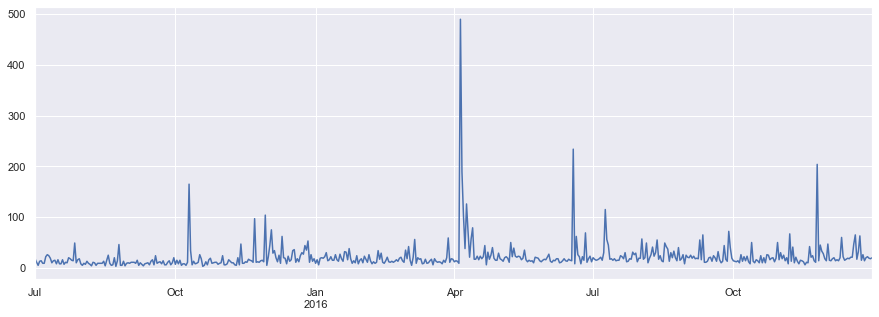

In [399]:
raw_time_series.plot(figsize=(15, 5));

In [409]:
df_time_series = pd.DataFrame(raw_time_series)
rename_dict = {0:'value'}
df_time_series.rename(columns=rename_dict, inplace=True)
df_time_series['day_of_week'] = df_time_series.index.dayofweek
df_time_series['day_name'] = df_time_series.index.day_name()
df_time_series['day_of_year'] = df_time_series.index.dayofyear
df_time_series['is_weekend'] = df_time_series.index.day_name().map(lambda x: True if x in ['Saturday', 'Sunday'] else False)
df_time_series['month'] = df_time_series.index.month
df_time_series['month_name'] = df_time_series.index.month_name()
df_time_series.value = df_time_series.value.map(float)

In [411]:
df_time_series.head()

,value,day_of_week,day_name,day_of_year,is_weekend,month,month_name
2015-07-01,18.0,2,Wednesday,182,False,7,July
2015-07-02,11.0,3,Thursday,183,False,7,July
2015-07-03,5.0,4,Friday,184,False,7,July
2015-07-04,13.0,5,Saturday,185,True,7,July
2015-07-05,14.0,6,Sunday,186,True,7,July


#### What are the days which people access this page the most?

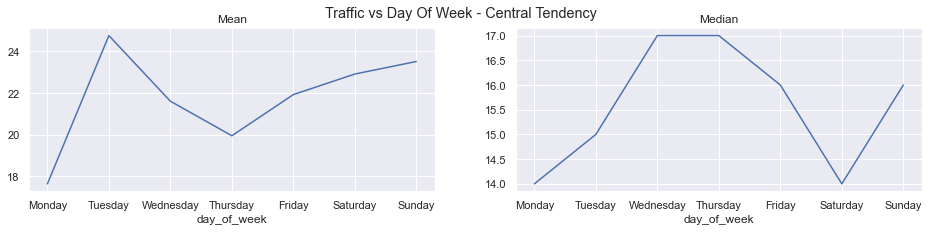

In [412]:
dict_day = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}
df_grouped_mean = df_time_series.groupby('day_of_week').mean()
df_grouped_mean.index = df_grouped_mean.index.map(lambda x: dict_day[x])

df_grouped_median = df_time_series.groupby('day_of_week').median()
df_grouped_median.index = df_grouped_median.index.map(lambda x: dict_day[x])

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16,3))
fig.suptitle('Traffic vs Day Of Week - Central Tendency')

df_grouped_mean.value.plot(ax=axes[0]);
axes[0].set_title('Mean');
df_grouped_median.value.plot(ax=axes[1]);
axes[1].set_title('Median');

Why so different plots?

Hipothesis: there are outliers within the series (for instance, if it's a christmas themed page, the traffic goes up only near christmas)

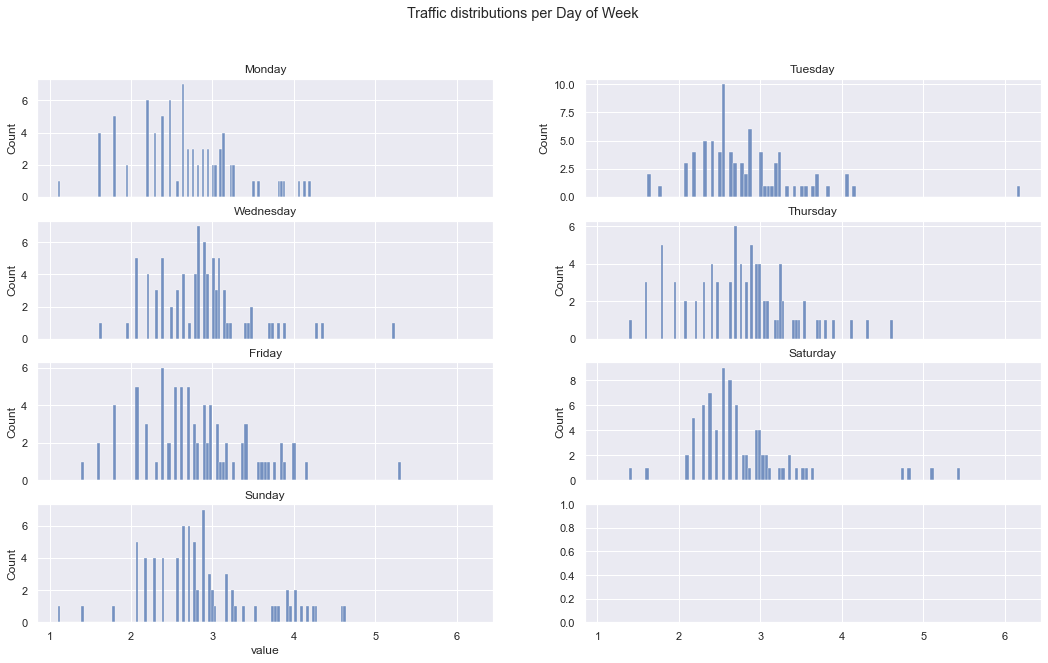

In [413]:
#Using log transformation so that the scale can be better interpreted
bins=100
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(18,10))
fig.suptitle('Traffic distributions per Day of Week')

sns.histplot(df_time_series[df_time_series.day_name == 'Monday'].value.map(lambda x: np.log(x)), ax=axes[0][0], bins=bins);
axes[0][0].set_title('Monday');

sns.histplot(df_time_series[df_time_series.day_name == 'Tuesday'].value.map(lambda x: np.log(x)), ax=axes[0][1], bins=bins);
axes[0][1].set_title('Tuesday');

sns.histplot(df_time_series[df_time_series.day_name == 'Wednesday'].value.map(lambda x: np.log(x)), ax=axes[1][0], bins=bins);
axes[1][0].set_title('Wednesday');

sns.histplot(df_time_series[df_time_series.day_name == 'Thursday'].value.map(lambda x: np.log(x)), ax=axes[1][1], bins=bins);
axes[1][1].set_title('Thursday');

sns.histplot(df_time_series[df_time_series.day_name == 'Friday'].value.map(lambda x: np.log(x)), ax=axes[2][0], bins=bins);
axes[2][0].set_title('Friday');

sns.histplot(df_time_series[df_time_series.day_name == 'Saturday'].value.map(lambda x: np.log(x)), ax=axes[2][1], bins=bins);
axes[2][1].set_title('Saturday');

sns.histplot(df_time_series[df_time_series.day_name == 'Sunday'].value.map(lambda x: np.log(x)), ax=axes[3][0], bins=bins);
axes[3][0].set_title('Sunday');

So, the median distribution is the best one. **Wednesday and Thursday** are the days in which people access this page the most.

#### Is the page traffic related to the month?

In [425]:
dict_month = {
    0:'Jan',
    1:'Feb',
    2:'Mar',
    3:'Apr',
    4:'May',
    5:'Jun',
    6:'Jul',
    7:'Aug',
    8:'Sept',
    9:'Oct',
    10:'Nov',
    11:'Dec'
}
df_grouped_mean = df_time_series.groupby('month').mean()
df_grouped_mean.index = df_grouped_mean.index.map(lambda x: dict_month[x-1])

<AxesSubplot:xlabel='month'>

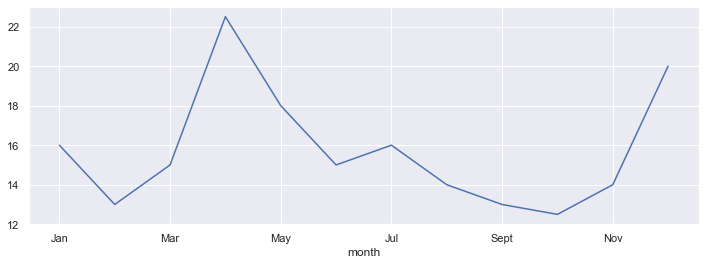

In [432]:
df_grouped_mean.value.plot(figsize=(12,4))

Apparently the traffic goes up on April and December. However, we can see below that we have more data regarding July to December than we have regarding January to June.

In [469]:
df_time_series.month.value_counts().sort_index()

1     31
2     29
3     31
4     30
5     31
6     30
7     62
8     62
9     60
10    62
11    60
12    62
Name: month, dtype: int64

In [147]:
result = seasonal_decompose(raw_time_series, model='additive')